<script async src="https://www.googletagmanager.com/gtag/js?id=UA-59152712-8"></script>
<script>
  window.dataLayer = window.dataLayer || [];
  function gtag(){dataLayer.push(arguments);}
  gtag('js', new Date());

  gtag('config', 'UA-59152712-8');
</script>

# `MaxwellVacuum`: Solving Maxwell Equations in Vacuum with NRPy+ and the Einstein Toolkit

## Authors: Terrence Pierre Jacques, Patrick Nelson, & Zach Etienne

## This notebook generates `MaxwellVacuum`, an [Einstein Toolkit](https://einsteintoolkit.org) thorn for solving Maxwell's equations in vacuum, in flat spacetime and Cartesian coordinates. This thorn is highly optimized for modern CPU architectures, featuring SIMD intrinsics and OpenMP support.

### Formatting improvements courtesy Brandon Clark

[comment]: <> (Abstract: TODO)

**Notebook Status:** <font color='green'><b> Validated</b></font> 

**Validation Notes:** As demonstrated [in the plot below](#code_validation), the numerical errors converge to zero at the expected rate, and we observe similar qualitatitve behavior of of the error nodes for Systems I (ADM - like) and II (BSSN - like). Also validated against the NRPy+ [Tutorial-Start_to_Finish-Solving_Maxwells_Equations_in_Vacuum-Cartesian](Tutorial-Start_to_Finish-Solving_Maxwells_Equations_in_Vacuum-Cartesian.ipynb) notebook.

### NRPy+ Source Code for this module: 
* [Maxwell/VacuumMaxwell_Flat_Evol_Cartesian.py](../edit/Maxwell/VacuumMaxwell_Flat_Evol_Cartesian.py) [\[**tutorial**\]](Tutorial-VacuumMaxwell_formulation_Cartesian.ipynb)

## Introduction:
This tutorial notebook constructs an Einstein Toolkit (ETK) thorn (module) that will set up expressions for the right-hand sides of Maxwell's equations as described in [Knapp, Walker, & Baumgarte (2002)](https://arxiv.org/abs/gr-qc/0201051) and the [NRPy+ `Tutorial-VacuumMaxwell_formulation_Cartesian` Jupyter notebook](Tutorial-VacuumMaxwell_formulation_Cartesian.ipynb), both for System I:

\begin{align}
\partial_t A^i &= -E^i - \partial^i \varphi, \\
\partial_t E^i &= \partial^i \partial_j A^j - \partial_j \partial^j A^i, \\
\partial_t \varphi &= -\partial_i A^i,
\end{align}

with associated constraint

$$
\partial_i E^i = 0,
$$

and for System II:

\begin{align}
\partial_t A^i &= -E^i - \partial^i \varphi, \\
\partial_t E^i &= \partial^i \Gamma - \partial_j \partial^j A^i, \\
\partial_t \Gamma &= - \partial_i \partial^i \varphi, \\
\partial_t \varphi &= -\Gamma,
\end{align}

with associated constraints

\begin{align}
\Gamma - \partial_i A^i &= 0, \\
\partial_i E^i &= 0.
\end{align}

This thorn is largely based on and should function similarly to the [`BaikalETK`](Tutorial-BaikalETK.ipynb) thorns, which solve Einstein's equations of general relativity in Cartesian coordinates, in the BSSN formalism. Further, we generate the C kernels for a number of finite difference orders, so that users are free to choose the finite-differencing order at runtime.

When interfaced properly with the ETK, this module will propagate the initial data for $E^i$, $A^i$, and $\varphi$ defined in [`MaxwellVacuumID`](Tutorial-ETK_thorn-MaxwellVacuumID.ipynb) forward in time by integrating the equations for $\partial_t E^i$, $\partial_t A^i$ and $\partial_t \varphi$ subject to spatial boundary conditions. The time evolution itself is handled by the `MoL` (Method of Lines) thorn in the `CactusNumerical` arrangement, and the boundary conditions by the `Boundary` thorn in the `CactusBase` arrangement. Specifically, we implement ETK's `NewRad` boundary condition driver, i.e. a radiation (Sommerfeld) boundary condition. 

Similar to the [`MaxwellVacuumID`](Tutorial-ETK_thorn-MaxwellVacuumID.ipynb) module, we will construct the MaxwellVacuum module in two steps.

1. Call on NRPy+ to convert the SymPy expressions for the evolution equations into C-code kernels.
1. Write the C code drivers and linkages to the Einstein Toolkit infrastructure (i.e., the .ccl files) to complete this Einstein Toolkit module.

The above steps will be performed in this notebook by first outputting *Python* code into a module, and then loading the Python module to generate the C code *in parallel* (using the [`multiprocessing`](https://docs.python.org/3/library/multiprocessing.html) built-in Python module).

<a id='toc'></a>

# Table of Contents
$$\label{toc}$$

This notebook is organized as follows

1. [Step 1](#initializenrpy): Initialize needed Python/NRPy+ modules
1. [Step 2](#mwev): NRPy+-generated C code kernels for Maxwell spacetime solve
    1. [Step 2.a](#mwevrhs): Maxwell RHS expressions
    1. [Step 2.b](#constraints): Divergence Constraint
    1. [Step 2.c](#driver_call_codegen_funcs):  Given `WhichPart` parameter choice, generate algorithm for calling corresponding function within `MaxwellVacuum_C_kernels_codegen_onepart()` to generate C code kernel 
    1. [Step 2.e](#kernel_codegen): Generate C code kernels for `MaxwellVacuum`
        1. [Step 2.e.i](#feature_choice): Set compile-time and runtime parameters for `MaxwellVacuum`
        1. [Step 2.e.ii](#parallel_codegen): Generate all C-code kernels for `MaxwellVacuum`, in parallel if possible
1. [Step 3](#cclfiles): CCL files - Define how this module interacts and interfaces with the wider Einstein Toolkit infrastructure
    1. [Step 3.a](#paramccl): `param.ccl`: specify free parameters within `MaxwellVacuum`
    1. [Step 3.b](#interfaceccl): `interface.ccl`: define needed gridfunctions; provide keywords denoting what this thorn provides and what it should inherit from other thorns
    1. [Step 3.c](#scheduleccl): `schedule.ccl`:schedule all functions used within `MaxwellVacuum`, specify data dependencies within said functions, and allocate memory for gridfunctions
1. [Step 4](#cdrivers): C driver functions for ETK registration & NRPy+ generated kernels
    1. [Step 4.a](#etkfunctions): Needed ETK functions: Banner, Symmetry registration, Parameter sanity check,  Method of Lines (`MoL`) registration, Boundary condition
    1. [Step 4.b](#mwevrhss) Evaluate Maxwell right-hand-sides (RHSs)
    1. [Step 4.c](#diagnostics): Diagnostics: Computing the divergence constraint

    1. [Step 4.d](#outcdrivers): Output all C driver functions needed for `MaxwellVacuum`
    1. [Step 4.e](#makecodedefn): `make.code.defn`: List of all C driver functions needed to compile `MaxwellVacuum`
1. [Step 5](#code_validation): Code Validation
    1. [Step 5.a](#convergence): Error Convergence
    1. [Step 5.b](#errornodes): Behavior of Error Nodes
1. [Step 6](#latex_pdf_output): Output this notebook to $\LaTeX$-formatted PDF file

<a id='initializenrpy'></a>

# Step 1: Initialize needed Python/NRPy+ modules \[Back to [top](#toc)\]

$$\label{initializenrpy}$$

In [1]:
MaxwellVacuumdir = "MaxwellNRPy_py_dir"
import cmdline_helper as cmd  # NRPy+: Multi-platform Python command-line interface
import os, sys                # Standard Python modules for multiplatform OS-level functions

cmd.mkdir(os.path.join(MaxwellVacuumdir))
# Write an empty __init__.py file in this directory so that Python2 can load modules from it.
with open(os.path.join(MaxwellVacuumdir, "__init__.py"), "w") as file:
    pass

In [2]:
%%writefile $MaxwellVacuumdir/MaxwellVacuum_C_kernels_codegen.py

# Step 1: Import needed core NRPy+ modules
from outputC import lhrh         # NRPy+: Core C code output module
import finite_difference as fin  # NRPy+: Finite difference C code generation module
import NRPy_param_funcs as par   # NRPy+: Parameter interface
import grid as gri               # NRPy+: Functions having to do with numerical grids
import loop as lp                # NRPy+: Generate C code loops
import indexedexp as ixp         # NRPy+: Symbolic indexed expression (e.g., tensors, vectors, etc.) support
import reference_metric as rfm   # NRPy+: Reference metric support
import os, sys                   # Standard Python modules for multiplatform OS-level functions
import time                      # Standard Python module; useful for benchmarking
import Maxwell.VacuumMaxwell_Flat_Evol_Cartesian as rhs

def MaxwellVacuum_C_kernels_codegen_onepart(params=
        "WhichPart=Maxwell_RHSs,ThornName=MaxwellVacuum,FD_order=4"):
    # Set default parameters
    WhichPart = "Maxwell_RHSs"
    ThornName = "MaxwellVacuum"
    FD_order = 4

    import re
    if params != "":
        params2 = re.sub("^,","",params)
        params = params2.strip()
        splitstring = re.split("=|,", params)

#         if len(splitstring) % 2 != 0:
#             print("outputC: Invalid params string: "+params)
#             sys.exit(1)

        parnm = []
        value = []
        for i in range(int(len(splitstring)/2)):
            parnm.append(splitstring[2*i])
            value.append(splitstring[2*i+1])

        for i in range(len(parnm)):
            parnm.append(splitstring[2*i])
            value.append(splitstring[2*i+1])

        for i in range(len(parnm)):
            if parnm[i] == "WhichPart":
                WhichPart = value[i]
            elif parnm[i] == "ThornName":
                ThornName = value[i]
            elif parnm[i] == "FD_order":
                FD_order = int(value[i])
            else:
                print("MaxwellVacuum Error: Could not parse input param: "+parnm[i])
                sys.exit(1)

    # Set output directory for C kernels
    outdir = os.path.join(ThornName, "src")  # Main C code output directory

    # Set spatial dimension (must be 3 for Maxwell)
    par.set_parval_from_str("grid::DIM",3)

    # Step 2: Set some core parameters, including CoordSystem MoL timestepping algorithm,
    #                                 FD order, floating point precision, and CFL factor:
    # Choices are: Spherical, SinhSpherical, SinhSphericalv2, Cylindrical, SinhCylindrical,
    #              SymTP, SinhSymTP
    # NOTE: Only CoordSystem == Cartesian makes sense here; new
    #       boundary conditions are needed within the ETK for
    #       Spherical, etc. coordinates.
    CoordSystem     = "Cartesian"

    par.set_parval_from_str("reference_metric::CoordSystem",CoordSystem)
    rfm.reference_metric() # Create ReU, ReDD needed for rescaling B-L initial data, generating Maxwell RHSs, etc.

    # Set the gridfunction memory access type to ETK-like, so that finite_difference
    #    knows how to read and write gridfunctions from/to memory.
    par.set_parval_from_str("grid::GridFuncMemAccess","ETK")

Overwriting MaxwellNRPy_py_dir/MaxwellVacuum_C_kernels_codegen.py


<a id='mwev'></a>

# Step 2: NRPy+-generated C code kernels for solving \[Back to [top](#toc)\]
$$\label{mwev}$$

<a id='mwevrhs'></a>

## Step 2.a: Maxwell RHS expressions \[Back to [top](#toc)\]
$$\label{mwevrhs}$$

`MaxwellVacuum` implements Maxwell's equations in flat spacetime and in Cartesian coordinates, which is fully documented within NRPy+ ([start here](Tutorial-VacuumMaxwell_formulation_Cartesian.ipynb)). 

Here, we simply call the [Maxwell/VacuumMaxwell_Flat_Evol_Cartesian.py](../edit/Maxwell/VacuumMaxwell_Flat_Evol_Cartesian.py); [\[**tutorial**\]](Tutorial-VacuumMaxwell_formulation_Cartesian.ipynb) NRPy+ Python module to generate the symbolic expressions and then output the finite-difference C code form of the equations using NRPy+'s [finite_difference](finite_difference.py) ([**tutorial**](Tutorial-Finite_Difference_Derivatives.ipynb)) C code generation module.


In [3]:
%%writefile -a $MaxwellVacuumdir/MaxwellVacuum_C_kernels_codegen.py

    def Maxwell_RHSs__generate_symbolic_expressions_SystemI():
        ######################################
        # START: GENERATE SYMBOLIC EXPRESSIONS
        print("Generating symbolic expressions for Maxwell RHSs SystemI...\n")
        start = time.time()

        # Set which system to use, which are defined in Maxwell/InitialData.py
        par.initialize_param(par.glb_param("char", "Maxwell.InitialData","System_to_use","System_I"))

        par.set_parval_from_str("reference_metric::enable_rfm_precompute","True")
        par.set_parval_from_str("reference_metric::rfm_precompute_Ccode_outdir",os.path.join(outdir,"rfm_files/"))

        rhs.VacuumMaxwellRHSs()

        end = time.time()
        print("(BENCH) Finished Maxwell RHS symbolic expressions in "+str(end-start)+" seconds.\n")
        # END: GENERATE SYMBOLIC EXPRESSIONS
        ######################################

        # Step 2: Register new gridfunctions so they can be written to by NRPy.
        # System I:
        AIU = ixp.register_gridfunctions_for_single_rank1("EVOL","AIU")
        EIU = ixp.register_gridfunctions_for_single_rank1("EVOL","EIU")
        psiI = gri.register_gridfunctions("EVOL","psiI")
        C_SystemI = rhs.C

        Maxwell_RHSs_SymbExpressions_SystemI = [\
                         lhrh(lhs=gri.gfaccess("rhs_gfs","AIU0"),rhs=rhs.ArhsU[0]),\
                         lhrh(lhs=gri.gfaccess("rhs_gfs","AIU1"),rhs=rhs.ArhsU[1]),\
                         lhrh(lhs=gri.gfaccess("rhs_gfs","AIU2"),rhs=rhs.ArhsU[2]),\
                         lhrh(lhs=gri.gfaccess("rhs_gfs","EIU0"),rhs=rhs.ErhsU[0]),\
                         lhrh(lhs=gri.gfaccess("rhs_gfs","EIU1"),rhs=rhs.ErhsU[1]),\
                         lhrh(lhs=gri.gfaccess("rhs_gfs","EIU2"),rhs=rhs.ErhsU[2]),\
                         lhrh(lhs=gri.gfaccess("rhs_gfs","psi"),rhs=rhs.psi_rhs)]

        # Avoid re-registering GFs later
        del gri.glb_gridfcs_list[:8]

        return [Maxwell_RHSs_SymbExpressions_SystemI, C_SystemI]

    def Maxwell_RHSs__generate_symbolic_expressions_SystemII():
        ######################################
        # START: GENERATE SYMBOLIC EXPRESSIONS
        print("Generating symbolic expressions for Maxwell RHSs SystemII...\n")
        start = time.time()

        # Set which system to use, which are defined in Maxwell/VacuumMaxwell_Flat_Cartesian_ID.py
        par.set_parval_from_str("Maxwell.InitialData::System_to_use","System_II")

        # Avoid re-registering GFs
        gri.glb_gridfcs_list = []

        rhs.VacuumMaxwellRHSs()

        end = time.time()
        print("(BENCH) Finished Maxwell RHS symbolic expressions in "+str(end-start)+" seconds.\n")
        # END: GENERATE SYMBOLIC EXPRESSIONS
        ######################################

        # Register gridfunctions so they can be written to by NRPy.
        # System II:
        AIIU = ixp.register_gridfunctions_for_single_rank1("EVOL","AIIU")
        EIIU = ixp.register_gridfunctions_for_single_rank1("EVOL","EIIU")
        psiII = gri.register_gridfunctions("EVOL","psiII")
        GammaII = gri.register_gridfunctions("EVOL","GammaII")
        C_SystemII = rhs.C
        G_SystemII = rhs.G

        Maxwell_RHSs_SymbExpressions_SystemII =  [\
                          lhrh(lhs=gri.gfaccess("rhs_gfs","AIIU0"),rhs=rhs.ArhsU[0]),\
                          lhrh(lhs=gri.gfaccess("rhs_gfs","AIIU1"),rhs=rhs.ArhsU[1]),\
                          lhrh(lhs=gri.gfaccess("rhs_gfs","AIIU2"),rhs=rhs.ArhsU[2]),\
                          lhrh(lhs=gri.gfaccess("rhs_gfs","EIIU0"),rhs=rhs.ErhsU[0]),\
                          lhrh(lhs=gri.gfaccess("rhs_gfs","EIIU1"),rhs=rhs.ErhsU[1]),\
                          lhrh(lhs=gri.gfaccess("rhs_gfs","EIIU2"),rhs=rhs.ErhsU[2]),\
                          lhrh(lhs=gri.gfaccess("rhs_gfs","psi"),rhs=rhs.psi_rhs),\
                          lhrh(lhs=gri.gfaccess("rhs_gfs","Gamma"),rhs=rhs.Gamma_rhs)]

        return [Maxwell_RHSs_SymbExpressions_SystemII, C_SystemII, G_SystemII]

    def Maxwell_RHSs__generate_Ccode(all_RHSs_exprs_list_SystemI, all_RHSs_exprs_list_SystemII):
        Maxwell_RHSs_SymbExpressions_SystemI  = all_RHSs_exprs_list_SystemI
        Maxwell_RHSs_SymbExpressions_SystemII = all_RHSs_exprs_list_SystemII

        print("Generating C code for Maxwell RHSs (FD_order="+str(FD_order)+") in "+par.parval_from_str("reference_metric::CoordSystem")+" coordinates.")
        start = time.time()

        # Store original finite-differencing order:
        FD_order_orig = par.parval_from_str("finite_difference::FD_CENTDERIVS_ORDER")
        # Set new finite-differencing order:
        par.set_parval_from_str("finite_difference::FD_CENTDERIVS_ORDER", FD_order)

        Maxwell_RHSs_string_SystemI = fin.FD_outputC("returnstring",Maxwell_RHSs_SymbExpressions_SystemI,
                                          params="outCverbose=False,SIMD_enable=True").replace("AU","AIU")\
                                                                    .replace("EU","EIU")\
                                                                    .replace("psi","psiI")

        Maxwell_RHSs_string_SystemII = fin.FD_outputC("returnstring",Maxwell_RHSs_SymbExpressions_SystemII,
                                          params="outCverbose=False,SIMD_enable=True").replace("AU","AIIU")\
                                                                    .replace("EU","EIIU")\
                                                                    .replace("psi","psiII")\
                                                                    .replace("Gamma","GammaII")


        filename = "Maxwell_RHSs"+"_FD_order_"+str(FD_order)+".h"
        with open(os.path.join(outdir,filename), "w") as file:
            file.write(lp.loop(["i2","i1","i0"],["cctk_nghostzones[2]","cctk_nghostzones[1]","cctk_nghostzones[0]"],
           ["cctk_lsh[2]-cctk_nghostzones[2]","cctk_lsh[1]-cctk_nghostzones[1]","cctk_lsh[0]-cctk_nghostzones[0]"],
                               ["1","1","SIMD_width"],
                                ["#pragma omp parallel for",
                                 "#include \"rfm_files/rfm_struct__SIMD_outer_read2.h\"",
                                 r"""    #include "rfm_files/rfm_struct__SIMD_outer_read1.h"
    #if (defined __INTEL_COMPILER && __INTEL_COMPILER_BUILD_DATE >= 20180804)
        #pragma ivdep         // Forces Intel compiler (if Intel compiler used) to ignore certain SIMD vector dependencies
        #pragma vector always // Forces Intel compiler (if Intel compiler used) to vectorize
    #endif"""],"",
                    "#include \"rfm_files/rfm_struct__SIMD_inner_read0.h\"\n"+Maxwell_RHSs_string_SystemI+Maxwell_RHSs_string_SystemII))

        # Restore original finite-differencing order:
        par.set_parval_from_str("finite_difference::FD_CENTDERIVS_ORDER", FD_order_orig)

        end = time.time()
        print("(BENCH) Finished Maxwell_RHS C codegen (FD_order="+str(FD_order)+") in " + str(end - start) + " seconds.\n")


Appending to MaxwellNRPy_py_dir/MaxwellVacuum_C_kernels_codegen.py


<a id='constraints'></a>

## Step 2.b: Constraints \[Back to [top](#toc)\]
$$\label{constraints}$$

Finally output the C code for evaluating the constraints, described in [this tutorial](Tutorial-VacuumMaxwell_Cartesian_RHSs.ipynb). In the absence of numerical error, the constraints should evaluate to zero, but due to numerical (typically truncation and roundoff) error they do not. We will therefore measure constraint violations to gauge the accuracy of our simulation, and ultimately determine whether errors are dominated by numerical finite differencing (truncation) error as expected.

In [4]:
%%writefile -a $MaxwellVacuumdir/MaxwellVacuum_C_kernels_codegen.py

    def Maxwell_constraints__generate_symbolic_expressions_and_C_code(C_SystemI,
                                                                      C_SystemII,
                                                                      G_SystemII):

        DivEI  = gri.register_gridfunctions("AUX", "DivEI")
        DivEII = gri.register_gridfunctions("AUX", "DivEII")
        GII    = gri.register_gridfunctions("AUX", "GII")

        # Store original finite-differencing order:
        FD_order_orig = par.parval_from_str("finite_difference::FD_CENTDERIVS_ORDER")
        # Set new finite-differencing order:
        par.set_parval_from_str("finite_difference::FD_CENTDERIVS_ORDER", FD_order)

        start = time.time()
        print("Generating optimized C code for constraints.")
        Constraints_string_SystemI = fin.FD_outputC("returnstring",
                                        [lhrh(lhs=gri.gfaccess("aux_gfs", "DivEI"),  rhs=C_SystemI)],
                                        params="outCverbose=False").replace("AU","AIU")\
                                                                   .replace("EU","EIU")\
                                                                   .replace("psi","psiI")

        Constraints_string_SystemII = fin.FD_outputC("returnstring",
                                        [lhrh(lhs=gri.gfaccess("aux_gfs", "DivEII"), rhs=C_SystemII),
                                         lhrh(lhs=gri.gfaccess("aux_gfs", "GII"),    rhs=G_SystemII)],
                                        params="outCverbose=False").replace("AU","AIIU")\
                                                                   .replace("EU","EIIU")\
                                                                   .replace("psi","psiII")\
                                                                   .replace("Gamma","GammaII")

        with open(os.path.join(outdir,"Maxwell_constraints"+"_FD_order_"+str(FD_order)+".h"), "w") as file:
            file.write(lp.loop(["i2","i1","i0"],["cctk_nghostzones[2]","cctk_nghostzones[1]","cctk_nghostzones[0]"],
           ["cctk_lsh[2]-cctk_nghostzones[2]","cctk_lsh[1]-cctk_nghostzones[1]","cctk_lsh[0]-cctk_nghostzones[0]"],
                               ["1","1","1"],["#pragma omp parallel for","",""], "",Constraints_string_SystemI+Constraints_string_SystemII))

        # Restore original finite-differencing order:
        par.set_parval_from_str("finite_difference::FD_CENTDERIVS_ORDER", FD_order_orig)

        end = time.time()
        print("(BENCH) Finished constraint C codegen (FD_order="+str(FD_order)+") in " + str(end - start) + " seconds.\n")

Appending to MaxwellNRPy_py_dir/MaxwellVacuum_C_kernels_codegen.py


<a id='driver_call_codegen_funcs'></a>

## Step 2.d: Given `WhichPart` parameter choice, generate algorithm for calling corresponding function within `MaxwellVacuum_C_kernels_codegen_onepart()` to generate C code kernel \[Back to [top](#toc)\]
$$\label{driver_call_codegen_funcs}$$

In [5]:
%%writefile -a $MaxwellVacuumdir/MaxwellVacuum_C_kernels_codegen.py


    SystemI_exprs  = Maxwell_RHSs__generate_symbolic_expressions_SystemI()
    SystemII_exprs = Maxwell_RHSs__generate_symbolic_expressions_SystemII()

    if WhichPart=="Maxwell_RHSs":
        Maxwell_RHSs__generate_Ccode(SystemI_exprs[0], SystemII_exprs[0])
    elif WhichPart=="Maxwell_constraints":
        Maxwell_constraints__generate_symbolic_expressions_and_C_code(SystemI_exprs[1],
                                                                     SystemII_exprs[1],
                                                                     SystemII_exprs[2])
    else:
        print("Error: WhichPart = "+WhichPart+" is not recognized.")
        sys.exit(1)

    # Avoid re-registering GFs
    del gri.glb_gridfcs_list[7:17]

    # Store all NRPy+ environment variables to an output string so NRPy+ environment from within this subprocess can be easily restored
    import pickle
    # https://www.pythonforthelab.com/blog/storing-binary-data-and-serializing/
    outstr = []
    outstr.append(pickle.dumps(len(gri.glb_gridfcs_list)))
    for lst in gri.glb_gridfcs_list:
        outstr.append(pickle.dumps(lst.gftype))
        outstr.append(pickle.dumps(lst.name))
        outstr.append(pickle.dumps(lst.rank))
        outstr.append(pickle.dumps(lst.DIM))

    outstr.append(pickle.dumps(len(par.glb_params_list)))
    for lst in par.glb_params_list:
        outstr.append(pickle.dumps(lst.type))
        outstr.append(pickle.dumps(lst.module))
        outstr.append(pickle.dumps(lst.parname))
        outstr.append(pickle.dumps(lst.defaultval))

    outstr.append(pickle.dumps(len(par.glb_Cparams_list)))
    for lst in par.glb_Cparams_list:
        outstr.append(pickle.dumps(lst.type))
        outstr.append(pickle.dumps(lst.module))
        outstr.append(pickle.dumps(lst.parname))
        outstr.append(pickle.dumps(lst.defaultval))
    return outstr

Appending to MaxwellNRPy_py_dir/MaxwellVacuum_C_kernels_codegen.py


<a id='kernel_codegen'></a>

## Step 2.c: Generate C code kernels for `MaxwellVacuum` \[Back to [top](#toc)\]
$$\label{kernel_codegen}$$

Here we generate the C code kernels (i.e., the C-code representation of the equations needed) for `MaxwellVacuum`.

<a id='feature_choice'></a>

### Step 2.c.i: Set compile-time and runtime parameters for `MaxwellVacuum`  \[Back to [top](#toc)\]
$$\label{feature_choice}$$

NRPy+ is a code generation package that is designed to offer maximum flexibility *at the time of C code generation*. As a result, although NRPy+ can in principle output an infinite variety of C code kernels for solving systems of partial differential equations, generally free parameters in each kernel steerable at *runtime* are restricted to simple scalars. This leads to more optimized kernels, but at the expense of flexibility in generating multiple kernels (e.g. one per finite-differencing order). Reducing the number of kernels and adding more flexibility at runtime will be a focus of future work.

For now, `MaxwellVacuum` supports the following runtime options:

* `MaxwellVacuum`: Evolution of the Maxwell's equations.
    * Finite differencing of orders 2, 4, 6, and 8 via runtime parameter `FD_order`

Next we set up the default parameter lists for `MaxwellVacuum_C_kernels_codegen_onepart()` for the `MaxwellVacuum` thorn. We set these parameter lists as strings to make parallelizing the code generation far easier (easier to pass a list of strings than a list of function arguments to Python's `multiprocessing.Pool()`).

In [6]:
# Step 2.e.i: Set compile-time and runtime parameters for Maxwell and MaxwellVacuum
#         Runtime parameters for
#         MaxwellVacuum: FD_orders = [2,4,6,8];

paramslist = []
FD_orders = [2,4,6,8]
WhichParamSet = 0
ThornName = "MaxwellVacuum"
for WhichPart in ["Maxwell_RHSs","Maxwell_constraints"]:
    for FD_order in FD_orders:
        paramstr = "WhichPart="+WhichPart+","
        paramstr+= "ThornName="+ThornName+","
        paramstr+= "FD_order="+str(FD_order)+","
        paramslist.append(paramstr)
        WhichParamSet = WhichParamSet + 1

paramslist.sort() # Sort the list alphabetically.

<a id='parallel_codegen'></a>

### Step 2.e.ii: Generate all C-code kernels for `MaxwellVacuum`, in parallel if possible \[Back to [top](#toc)\]
$$\label{parallel_codegen}$$

In [7]:
nrpy_dir_path = os.path.join(".")
if nrpy_dir_path not in sys.path:
    sys.path.append(nrpy_dir_path)

# Create all output directories if they do not yet exist
import cmdline_helper as cmd    # NRPy+: Multi-platform Python command-line interface
for ThornName in ["MaxwellVacuum"]:
    outrootdir = ThornName
    cmd.mkdir(os.path.join(outrootdir))
    outdir = os.path.join(outrootdir,"src") # Main C code output directory

    # Copy SIMD/SIMD_intrinsics.h to $outdir/SIMD/SIMD_intrinsics.h, replacing
    #   the line "#define REAL_SIMD_ARRAY REAL" with "#define REAL_SIMD_ARRAY CCTK_REAL"
    #   (since REAL is undefined in the ETK, but CCTK_REAL takes its place)
    cmd.mkdir(os.path.join(outdir,"SIMD"))
    import fileinput
    f = fileinput.input(os.path.join(nrpy_dir_path,"SIMD","SIMD_intrinsics.h"))
    with open(os.path.join(outdir,"SIMD","SIMD_intrinsics.h"),"w") as outfile:
        for line in f:
            outfile.write(line.replace("#define REAL_SIMD_ARRAY REAL", "#define REAL_SIMD_ARRAY CCTK_REAL"))

    # Create directory for rfm_files output
    cmd.mkdir(os.path.join(outdir,"rfm_files"))

# Start parallel C code generation (codegen)
# NRPyEnvVars stores the NRPy+ environment from all the subprocesses in the following
#     parallel codegen
NRPyEnvVars = []

import time   # Standard Python module for benchmarking
import logging
start = time.time()
if __name__ == "__main__":
#     try:
#         if os.name == 'nt':
#             # Windows & Jupyter multiprocessing do not mix, so we run in serial on Windows.
#             #  Here's why: https://stackoverflow.com/questions/45719956/python-multiprocessing-in-jupyter-on-windows-attributeerror-cant-get-attribut
#             raise Exception("Parallel codegen currently not available in Windows")
#         # Step 3.d.ii: Import the multiprocessing module.
#         import multiprocessing
#         print("***************************************")
#         print("Starting parallel C kernel codegen...")
#         print("***************************************")

#         # Step 3.d.iii: Define master function for parallelization.
#         #           Note that lambdifying this doesn't work in Python 3
#         def master_func(i):
#             import MaxwellNRPy_py_dir.MaxwellVacuum_C_kernels_codegen as MCk
#             return MCk.MaxwellVacuum_C_kernels_codegen_onepart(params=paramslist[i])

#         # Step 3.d.iv: Evaluate list of functions in parallel if possible;
#         #           otherwise fallback to serial evaluation:
#         pool = multiprocessing.Pool() #processes=len(paramslist))
#         NRPyEnvVars.append(pool.map(master_func,range(len(paramslist))))
#         pool.terminate()
#         pool.join()
#     except:
#         logging.exception("Ignore this warning/backtrace if on a system in which serial codegen is necessary:")
    print("***************************************")
    print("Starting serial C kernel codegen...")
    print("***************************************")
    # Steps 3.d.ii-iv, alternate: As fallback, evaluate functions in serial.
    #       This will happen on Android and Windows systems
    import MaxwellNRPy_py_dir.MaxwellVacuum_C_kernels_codegen as MCk
    import grid as gri
    for param in paramslist:
        gri.glb_gridfcs_list = []
        MCk.MaxwellVacuum_C_kernels_codegen_onepart(params=param)
    NRPyEnvVars = [] # Reset NRPyEnvVars in case multiprocessing wrote to it and failed.
# # Steps 3.d.ii-iv, alternate: As fallback, evaluate functions in serial.
# #       This will happen on Android and Windows systems

print("(BENCH) Finished C kernel codegen for MaxwellVacuum in "+str(time.time()-start)+" seconds.\n")

***************************************
Starting serial C kernel codegen...
***************************************
Generating symbolic expressions for Maxwell RHSs SystemI...

Currently using System_I RHSs 

(BENCH) Finished Maxwell RHS symbolic expressions in 0.02069687843322754 seconds.

Generating symbolic expressions for Maxwell RHSs SystemII...

Currently using System_II RHSs 

(BENCH) Finished Maxwell RHS symbolic expressions in 0.019797563552856445 seconds.

Generating C code for Maxwell RHSs (FD_order=2) in Cartesian coordinates.
(BENCH) Finished Maxwell_RHS C codegen (FD_order=2) in 0.6086132526397705 seconds.

Generating symbolic expressions for Maxwell RHSs SystemI...

Currently using System_II RHSs 

(BENCH) Finished Maxwell RHS symbolic expressions in 0.02014780044555664 seconds.

Generating symbolic expressions for Maxwell RHSs SystemII...

Currently using System_II RHSs 

(BENCH) Finished Maxwell RHS symbolic expressions in 0.017313480377197266 seconds.

Generating C co

In [8]:
%tb

No traceback available to show.


<a id='cclfiles'></a>

# Step 3: ETK `ccl` file generation \[Back to [top](#toc)\]
$$\label{cclfiles}$$

The Einstein Toolkit (ETK) ccl files contain runtime parameters (`param.ccl`), registered gridfunctions (`interface.ccl`), and function scheduling (`schedule.ccl`). As parameters and gridfunctions are registered with NRPy+ when the C-code kernels are generated, and this generation occurs on separate processes in parallel, we store the entire NRPy+ environment for *each* process. This results in a tremendous amount of duplication, which is sorted out next. Once all duplicated environment variables (e.g., registered gridfunctions) are removed, we replace the current NRPy+ environment with the new one, by setting `gri.glb_gridfcs_list[],par.glb_params_list[],par.glb_Cparams_list[]`.

In [9]:
# Store all NRPy+ environment variables to file so NRPy+ environment from within this subprocess can be easily restored
import pickle                   # Standard Python module for converting arbitrary data structures to a uniform format.
import grid as gri              # NRPy+: Functions having to do with numerical grids
import NRPy_param_funcs as par  # NRPy+: Parameter interface

if len(NRPyEnvVars) > 0:
    # https://www.pythonforthelab.com/blog/storing-binary-data-and-serializing/
    grfcs_list = []
    param_list = []
    Cparm_list = []

    for WhichParamSet in NRPyEnvVars[0]:
        # gridfunctions
        i=0
        # print("Length of WhichParamSet:",str(len(WhichParamSet)))
        num_elements = pickle.loads(WhichParamSet[i]); i+=1
        for lst in range(num_elements):
            grfcs_list.append(gri.glb_gridfc(gftype=pickle.loads(WhichParamSet[i+0]),
                                             name  =pickle.loads(WhichParamSet[i+1]),
                                             rank  =pickle.loads(WhichParamSet[i+2]),
                                             DIM   =pickle.loads(WhichParamSet[i+3]))) ; i+=4
        # parameters
        num_elements = pickle.loads(WhichParamSet[i]); i+=1
        for lst in range(num_elements):
            param_list.append(par.glb_param(type      =pickle.loads(WhichParamSet[i+0]),
                                            module    =pickle.loads(WhichParamSet[i+1]),
                                            parname   =pickle.loads(WhichParamSet[i+2]),
                                            defaultval=pickle.loads(WhichParamSet[i+3]))) ; i+=4
        # Cparameters
        num_elements = pickle.loads(WhichParamSet[i]); i+=1
        for lst in range(num_elements):
            Cparm_list.append(par.glb_Cparam(type      =pickle.loads(WhichParamSet[i+0]),
                                             module    =pickle.loads(WhichParamSet[i+1]),
                                             parname   =pickle.loads(WhichParamSet[i+2]),
                                             defaultval=pickle.loads(WhichParamSet[i+3]))) ; i+=4
    grfcs_list_uniq = []
    for gf_ntuple_stored in grfcs_list:
        found_gf = False
        for gf_ntuple_new in grfcs_list_uniq:
            if gf_ntuple_new == gf_ntuple_stored:
                found_gf = True
        if found_gf == False:
            grfcs_list_uniq.append(gf_ntuple_stored)

    param_list_uniq = []
    for pr_ntuple_stored in param_list:
        found_pr = False
        for pr_ntuple_new in param_list_uniq:
            if pr_ntuple_new == pr_ntuple_stored:
                found_pr = True
        if found_pr == False:
            param_list_uniq.append(pr_ntuple_stored)

    # Set glb_paramsvals_list:
    # Step 1: Reset all paramsvals to their defaults
    par.glb_paramsvals_list = []
    for parm in param_list_uniq:
        par.glb_paramsvals_list.append(parm.defaultval)

    Cparm_list_uniq = []
    for Cp_ntuple_stored in Cparm_list:
        found_Cp = False
        for Cp_ntuple_new in Cparm_list_uniq:
            if Cp_ntuple_new == Cp_ntuple_stored:
                found_Cp = True
        if found_Cp == False:
            Cparm_list_uniq.append(Cp_ntuple_stored)

    gri.glb_gridfcs_list = []
    par.glb_params_list  = []
    par.glb_Cparams_list = []

    gri.glb_gridfcs_list = grfcs_list_uniq
    par.glb_params_list  = param_list_uniq
    par.glb_Cparams_list = Cparm_list_uniq

<a id='paramccl'></a>

## Step 3.a: `param.ccl`: specify free parameters within `MaxwellVacuum` \[Back to [top](#toc)\]
$$\label{paramccl}$$

All parameters necessary to evolve the right-hand side (RHS) expressions of Maxwell's equations are registered within NRPy+; we use this information to automatically generate `param.ccl`. NRPy+ also specifies default values for each parameter. 

More information on `param.ccl` syntax can be found in the [official Einstein Toolkit documentation](http://einsteintoolkit.org/usersguide/UsersGuide.html#x1-184000D2.3).

In [10]:
%%writefile $MaxwellVacuumdir/MaxwellVacuum_ETK_ccl_files_codegen.py

# Step 1: Import needed core NRPy+ modules
import NRPy_param_funcs as par # NRPy+: Parameter interface
import grid as gri             # NRPy+: Functions having to do with numerical grids
import os, sys                 # Standard Python modules for multiplatform OS-level functions

def keep_param__return_type(paramtuple):
    keep_param = True # We'll not set some parameters in param.ccl;
                      #   e.g., those that should be #define'd like M_PI.
    typestring = ""
    # Separate thorns within the ETK take care of grid/coordinate parameters;
    #   thus we ignore NRPy+ grid/coordinate parameters:
    if paramtuple.module == "grid" or paramtuple.module == "reference_metric":
        keep_param = False

    partype = paramtuple.type
    if partype == "bool":
        typestring += "BOOLEAN "
    elif partype == "REAL":
        if paramtuple.defaultval != 1e300: # 1e300 is a magic value indicating that the C parameter should be mutable
            typestring += "CCTK_REAL "
        else:
            keep_param = False
    elif partype == "int":
        typestring += "CCTK_INT "
    elif partype == "#define":
        keep_param = False
    elif partype == "char":
        # FIXME: char/string parameter types should in principle be supported
        print("Error: parameter "+paramtuple.module+"::"+paramtuple.parname+
              " has unsupported type: \""+ paramtuple.type + "\"")
        sys.exit(1)
    else:
        print("Error: parameter "+paramtuple.module+"::"+paramtuple.parname+
              " has unsupported type: \""+ paramtuple.type + "\"")
        sys.exit(1)
    return keep_param, typestring

def output_param_ccl(ThornName="MaxwellVacuum"):
    with open(os.path.join(ThornName,"param.ccl"), "w") as file:
        file.write("""
# This param.ccl file was automatically generated by NRPy+.
#   You are advised against modifying it directly; instead
#   modify the Python code that generates it.

shares: MethodOfLines

#EXTENDS CCTK_KEYWORD evolution_method "evolution_method"
#{
#  "MaxwellVacuum" :: ""
#}

restricted:

CCTK_INT FD_order "Finite-differencing order"
{\n""")
        FDorders = []
        for _root, _dirs, files in os.walk(os.path.join(ThornName,"src")): # _root,_dirs unused.
            for Cfilename in files:
                if (".h" in Cfilename) and ("RHSs" in Cfilename) and ("intrinsics" not in Cfilename):
                    array = Cfilename.replace(".","_").split("_")
                    FDorders.append(int(array[-2]))
        FDorders.sort()
        for order in FDorders:
            file.write(" "+str(order)+":"+str(order)+"   :: \"finite-differencing order = "+str(order)+"\"\n")
        FDorder_default = 4
        if FDorder_default not in FDorders:
            print("WARNING: 4th-order FD kernel was not output!?! Changing default FD order to "+str(FDorders[0]))
            FDorder_default = FDorders[0]
        file.write("} "+str(FDorder_default)+ "\n\n") # choose 4th order by default, consistent with ML_Maxwell
        paramccl_str = ""
        for i in range(len(par.glb_Cparams_list)):
            # keep_param is a boolean indicating whether we should accept or reject
            #    the parameter. singleparstring will contain the string indicating
            #    the variable type.
            keep_param, singleparstring = keep_param__return_type(par.glb_Cparams_list[i])

            if keep_param:
                parname = par.glb_Cparams_list[i].parname
                partype = par.glb_Cparams_list[i].type
                singleparstring += parname + " \""+ parname +" (see NRPy+ for parameter definition)\"\n"
                singleparstring += "{\n"
                if partype != "bool":
                    singleparstring += " *:* :: \"All values accepted. NRPy+ does not restrict the allowed ranges of parameters yet.\"\n"
                singleparstring += "} "+str(par.glb_Cparams_list[i].defaultval)+"\n\n"

                paramccl_str += singleparstring
        file.write(paramccl_str)

Overwriting MaxwellNRPy_py_dir/MaxwellVacuum_ETK_ccl_files_codegen.py


<a id='interfaceccl'></a>

## Step 3.b: `interface.ccl`: define needed gridfunctions; provide keywords denoting what this thorn provides and what it should inherit from other thorns \[Back to [top](#toc)\]
$$\label{interfaceccl}$$

`interface.ccl` declares all gridfunctions and determines how `MaxwellVacuum` interacts with other Einstein Toolkit thorns.

The [official Einstein Toolkit (Cactus) documentation](http://einsteintoolkit.org/usersguide/UsersGuide.html#x1-179000D2.2) defines what must/should be included in an `interface.ccl` file.

In [11]:
%%writefile -a $MaxwellVacuumdir/MaxwellVacuum_ETK_ccl_files_codegen.py

# First construct lists of the basic gridfunctions used in NRPy+.
#    Each type will be its own group in MaxwellVacuum.
evol_gfs_list    = []
auxevol_gfs_list = []
aux_gfs_list     = []
for i in range(len(gri.glb_gridfcs_list)):
    if gri.glb_gridfcs_list[i].gftype == "EVOL":
        evol_gfs_list.append(   gri.glb_gridfcs_list[i].name+"GF")

    if gri.glb_gridfcs_list[i].gftype == "AUX":
        aux_gfs_list.append(    gri.glb_gridfcs_list[i].name+"GF")

    if gri.glb_gridfcs_list[i].gftype == "AUXEVOL":
        auxevol_gfs_list.append(gri.glb_gridfcs_list[i].name+"GF")

# NRPy+'s finite-difference code generator assumes gridfunctions
#    are alphabetized; not sorting may result in unnecessary
#    cache misses.
evol_gfs_list.sort()
aux_gfs_list.sort()
auxevol_gfs_list.sort()
rhs_list = []
for gf in evol_gfs_list:
    rhs_list.append(gf.replace("GF","")+"_rhsGF")

def output_interface_ccl(ThornName="MaxwellVacuum"):
    outstr = """
# This interface.ccl file was automatically generated by NRPy+.
#   You are advised against modifying it directly; instead
#   modify the Python code that generates it.

# With "implements", we give our thorn its unique name.
implements: MaxwellVacuum

# By "inheriting" other thorns, we tell the Toolkit that we
#   will rely on variables/function that exist within those
#   functions.
inherits: Boundary grid MethodofLines\n"""

    outstr += """
# Needed functions and #include's:
USES INCLUDE: Symmetry.h
USES INCLUDE: Boundary.h

# Needed Method of Lines function
CCTK_INT FUNCTION MoLRegisterEvolvedGroup(CCTK_INT IN EvolvedIndex, \
                                          CCTK_INT IN RHSIndex)
REQUIRES FUNCTION MoLRegisterEvolvedGroup

# Needed Boundary Conditions function
CCTK_INT FUNCTION GetBoundarySpecification(CCTK_INT IN size, CCTK_INT OUT ARRAY nboundaryzones, CCTK_INT OUT ARRAY is_internal, CCTK_INT OUT ARRAY is_staggered, CCTK_INT OUT ARRAY shiftout)
USES FUNCTION GetBoundarySpecification

CCTK_INT FUNCTION SymmetryTableHandleForGrid(CCTK_POINTER_TO_CONST IN cctkGH)
USES FUNCTION SymmetryTableHandleForGrid

CCTK_INT FUNCTION Boundary_SelectVarForBC(CCTK_POINTER_TO_CONST IN GH, CCTK_INT IN faces, CCTK_INT IN boundary_width, CCTK_INT IN table_handle, CCTK_STRING IN var_name, CCTK_STRING IN bc_name)
USES FUNCTION Boundary_SelectVarForBC

# Needed for EinsteinEvolve/NewRad outer boundary condition driver:
CCTK_INT FUNCTION                         \\
    NewRad_Apply                          \\
        (CCTK_POINTER_TO_CONST IN cctkGH, \\
         CCTK_REAL ARRAY IN var,          \\
         CCTK_REAL ARRAY INOUT rhs,       \\
         CCTK_REAL IN var0,               \\
         CCTK_REAL IN v0,                 \\
         CCTK_INT IN radpower)
REQUIRES FUNCTION NewRad_Apply

# Tell the Toolkit that we want all gridfunctions
#    to be visible to other thorns by using
#    the keyword "public". Note that declaring these
#    gridfunctions *does not* allocate memory for them;
#    that is done by the schedule.ccl file.

public:
"""

    # Next we declare gridfunctions based on their corresponding gridfunction groups as registered within NRPy+

    def output_list_of_gfs(gfs_list,description="User did not provide description"):
        gfsstr = "    "
        for i in range(len(gfs_list)):
            gfsstr += gfs_list[i]
            if i != len(gfs_list)-1:
                gfsstr += "," # This is a comma-separated list of gridfunctions
            else:
                gfsstr += "\n} \""+description+"\"\n\n"
        return gfsstr
    # First EVOL type:
    outstr += "CCTK_REAL evol_variables type = GF Timelevels=3\n{\n"
    outstr += output_list_of_gfs(evol_gfs_list,"Maxwell evolved gridfunctions")
    # Second EVOL right-hand-sides
    outstr += "CCTK_REAL evol_variables_rhs type = GF Timelevels=1 TAGS=\'InterpNumTimelevels=1 prolongation=\"none\"\'\n{\n"
    outstr += output_list_of_gfs(rhs_list,"right-hand-side storage for Maxwell evolved gridfunctions")
    # Then AUX type:
    outstr += "CCTK_REAL aux_variables type = GF Timelevels=3\n{\n"
    outstr += output_list_of_gfs(aux_gfs_list,"Auxiliary gridfunctions for Maxwell diagnostics")
    # Finally, AUXEVOL type:
#     outstr += "CCTK_REAL auxevol_variables type = GF Timelevels=1 TAGS=\'InterpNumTimelevels=1 prolongation=\"none\"\'\n{\n"
#     outstr += output_list_of_gfs(auxevol_gfs_list,"Auxiliary gridfunctions needed for evaluating the Maxwell RHSs")

    with open(os.path.join(ThornName,"interface.ccl"), "w") as file:
        file.write(outstr.replace("MaxwellVacuum",ThornName))

Appending to MaxwellNRPy_py_dir/MaxwellVacuum_ETK_ccl_files_codegen.py


<a id='scheduleccl'></a>

## Step 3.c: `schedule.ccl`: schedule all functions used within `MaxwellVacuum`, specify data dependencies within said functions, and allocate memory for gridfunctions \[Back to [top](#toc)\]
$$\label{scheduleccl}$$

Official documentation on constructing ETK `schedule.ccl` files is found [here](http://einsteintoolkit.org/usersguide/UsersGuide.html#x1-187000D2.4).

In [12]:
%%writefile -a $MaxwellVacuumdir/MaxwellVacuum_ETK_ccl_files_codegen.py

def output_schedule_ccl(ThornName="MaxwellVacuum"):
    outstr = """
# This schedule.ccl file was automatically generated by NRPy+.
#   You are advised against modifying it directly; instead
#   modify the Python code that generates it.

# Next allocate storage for all 3 gridfunction groups used in MaxwellVacuum
STORAGE: evol_variables[3]     # Evolution variables
STORAGE: evol_variables_rhs[1] # Variables storing right-hand-sides
STORAGE: aux_variables[3]      # Diagnostics variables

# The following scheduler is based on Lean/LeanMaxwellMoL/schedule.ccl

schedule MaxwellVacuum_Banner at STARTUP
{
  LANG: C
  OPTIONS: meta
} "Output ASCII art banner"

schedule MaxwellVacuum_Symmetry_registration at BASEGRID
{
  LANG: C
  OPTIONS: Global
} "Register symmetries, the CartGrid3D way."

schedule MaxwellVacuum_zero_rhss at BASEGRID after MaxwellVacuum_Symmetry_registration
{
  LANG: C
} "Idea from Lean: set all rhs functions to zero to prevent spurious nans"

# MoL: registration

schedule MaxwellVacuum_MoL_registration in MoL_Register
{
  LANG: C
  OPTIONS: META
} "Register variables for MoL"

# MoL: compute RHSs, etc

schedule MaxwellVacuum_RHSs in MoL_CalcRHS as MaxwellVacuum_RHS
{
  LANG: C
} "MoL: Evaluate Maxwell RHSs"

schedule MaxwellVacuum_NewRad in MoL_CalcRHS after MaxwellVacuum_RHS
{
  LANG: C
} "NewRad boundary conditions, scheduled right after RHS eval."

schedule MaxwellVacuum_BoundaryConditions_evolved_gfs in MoL_PostStep
{
  LANG: C
  OPTIONS: LEVEL
  SYNC: evol_variables
} "Apply boundary conditions and perform AMR+interprocessor synchronization"

schedule GROUP ApplyBCs as MaxwellVacuum_ApplyBCs in MoL_PostStep after MaxwellVacuum_BoundaryConditions_evolved_gfs
{
} "Group for applying boundary conditions"

# Compute divergence and Gamma constraints

schedule MaxwellVacuum_constraints in MoL_PseudoEvolution
{
  LANG: C
  OPTIONS: Local
} "Compute Maxwell (divergence and Gamma) constraints"
"""
    with open(os.path.join(ThornName,"schedule.ccl"), "w") as file:
        file.write(outstr.replace("MaxwellVacuum",ThornName))

Appending to MaxwellNRPy_py_dir/MaxwellVacuum_ETK_ccl_files_codegen.py


In [13]:
import MaxwellNRPy_py_dir.MaxwellVacuum_ETK_ccl_files_codegen as cclgen

ThornName="MaxwellVacuum"
cclgen.output_param_ccl(ThornName)
cclgen.output_interface_ccl(ThornName)
cclgen.output_schedule_ccl(ThornName)

<a id='cdrivers'></a>

# Step 4: C driver functions for ETK registration & NRPy+ generated kernels \[Back to [top](#toc)\]
$$\label{cdrivers}$$

Now that we have constructed the basic C code kernels and the needed Einstein Toolkit `ccl` files, we next write the driver functions for registering `MaxwellVacuum` within the Toolkit and the C code kernels. Each of these driver functions will be called directly from the thorn's [`schedule.ccl`](#scheduleccl) in the ETK.

<a id='etkfunctions'></a>
## Step 4.a: Needed ETK functions: Banner, Symmetry registration, Parameter sanity check,  Method of Lines (`MoL`) registration, Boundary condition \[Back to [top](#toc)\]
$$\label{etkfunctions}$$

### To-do: Parameter sanity check function. E.g., error should be thrown if `cctk_nghostzones[]` is set too small for the chosen finite-differencing order within NRPy+.

In [14]:
%%writefile $MaxwellVacuumdir/MaxwellVacuum_C_drivers_codegen.py

# Step 1: Import needed core NRPy+ and Python modules
from outputC import lhrh         # NRPy+: Core C code output module
import NRPy_param_funcs as par   # NRPy+: Parameter interface
import finite_difference as fin  # NRPy+: Finite difference C code generation module
import grid as gri               # NRPy+: Functions having to do with numerical grids
import loop as lp                # NRPy+: Generate C code loops
import indexedexp as ixp         # NRPy+: Symbolic indexed expression (e.g., tensors, vectors, etc.) support
import os, sys                   # Standard Python modules for multiplatform OS-level functions
# We need the function keep_param__return_type() from this module:
import MaxwellNRPy_py_dir.MaxwellVacuum_ETK_ccl_files_codegen as ccl

make_code_defn_list = []
def append_to_make_code_defn_list(filename):
    if filename not in make_code_defn_list:
        make_code_defn_list.append(filename)
    return filename

Overwriting MaxwellNRPy_py_dir/MaxwellVacuum_C_drivers_codegen.py


In [15]:
%%writefile -a $MaxwellVacuumdir/MaxwellVacuum_C_drivers_codegen.py

def driver_C_codes(Csrcdict, ThornName,
                   rhs_list,evol_gfs_list,aux_gfs_list,auxevol_gfs_list):
    # First the ETK banner code, proudly showing the NRPy+ banner
    import NRPy_logo as logo
    outstr = """
#include <stdio.h>

void MaxwellVacuum_Banner()
{
    """
    logostr = logo.print_logo(print_to_stdout=False)
    outstr += "printf(\"MaxwellVacuum: another Einstein Toolkit thorn generated by\\n\");\n"
    for line in logostr.splitlines():
        outstr += "    printf(\""+line+"\\n\");\n"
    outstr += "}\n"

    # Finally add C code string to dictionaries (Python dictionaries are immutable)
    # Add C code string to dictionary (Python dictionaries are immutable)
    Csrcdict[append_to_make_code_defn_list("Banner.c")] = outstr.replace("MaxwellVacuum",ThornName)

Appending to MaxwellNRPy_py_dir/MaxwellVacuum_C_drivers_codegen.py


In [16]:
%%writefile -a $MaxwellVacuumdir/MaxwellVacuum_C_drivers_codegen.py

    # Next MaxwellVacuum_Symmetry_registration(): Register symmetries

    full_gfs_list = []
    full_gfs_list.extend(evol_gfs_list)
    full_gfs_list.extend(auxevol_gfs_list)
    full_gfs_list.extend(aux_gfs_list)

    outstr = """
#include "cctk.h"
#include "cctk_Arguments.h"
#include "cctk_Parameters.h"
#include "Symmetry.h"

void MaxwellVacuum_Symmetry_registration(CCTK_ARGUMENTS)
{
  DECLARE_CCTK_ARGUMENTS;
  DECLARE_CCTK_PARAMETERS;

  // Stores gridfunction parity across x=0, y=0, and z=0 planes, respectively
  int sym[3];

  // Next register parities for each gridfunction based on its name
  //    (to ensure this algorithm is robust, gridfunctions with integers
  //     in their base names are forbidden in NRPy+).
"""
    outstr += ""
    for gfname in full_gfs_list:
        gfname_without_GFsuffix = gfname[:-2]
        outstr += """
      // Default to scalar symmetry:
      sym[0] = 1; sym[1] = 1; sym[2] = 1;
      // Now modify sym[0], sym[1], and/or sym[2] as needed
      //    to account for gridfunction parity across
      //    x=0, y=0, and/or z=0 planes, respectively
"""
        # If gridfunction name does not end in a digit, by NRPy+ syntax, it must be a scalar
        if gfname_without_GFsuffix[len(gfname_without_GFsuffix) - 1].isdigit() == False:
            outstr += "      // (this gridfunction is a scalar -- no need to change default sym[]'s!)\n"
        elif len(gfname_without_GFsuffix) > 2:
            # Rank-1 indexed expression (e.g., vector)
            if gfname_without_GFsuffix[len(gfname_without_GFsuffix) - 2].isdigit() == False:
                if int(gfname_without_GFsuffix[-1]) > 2:
                    print("Error: Found invalid gridfunction name: "+gfname)
                    sys.exit(1)
                symidx = gfname_without_GFsuffix[-1]
                if int(symidx) < 3:   outstr += "      sym[" + symidx + "] = -1;\n"
            # Rank-2 indexed expression
            elif gfname_without_GFsuffix[len(gfname_without_GFsuffix) - 2].isdigit() == True:
                if len(gfname_without_GFsuffix) > 3 and gfname_without_GFsuffix[len(gfname_without_GFsuffix) - 3].isdigit() == True:
                    print("Error: Found a Rank-3 or above gridfunction: "+gfname+", which is at the moment unsupported.")
                    print("It should be easy to support this if desired.")
                    sys.exit(1)
                symidx0 = gfname_without_GFsuffix[-2]
                if int(symidx0) >= 0: outstr += "      sym[" + symidx0 + "] *= -1;\n"
                symidx1 = gfname_without_GFsuffix[-1]
                if int(symidx1) >= 0: outstr += "      sym[" + symidx1 + "] *= -1;\n"
        else:
            print("Don't know how you got this far with a gridfunction named "+gfname+", but I'll take no more of this nonsense.")
            print("   Please follow best-practices and rename your gridfunction to be more descriptive")
            sys.exit(1)
        outstr += "      SetCartSymVN(cctkGH, sym, \"MaxwellVacuum::" + gfname + "\");\n"
    outstr += "}\n"

    # Add C code string to dictionary (Python dictionaries are immutable)
    Csrcdict[append_to_make_code_defn_list("Symmetry_registration_oldCartGrid3D.c")] = \
        outstr.replace("MaxwellVacuum",ThornName)

Appending to MaxwellNRPy_py_dir/MaxwellVacuum_C_drivers_codegen.py


In [17]:
%%writefile -a $MaxwellVacuumdir/MaxwellVacuum_C_drivers_codegen.py

    # Next set RHSs to zero
    outstr = """
#include "cctk.h"
#include "cctk_Arguments.h"
#include "cctk_Parameters.h"
#include "Symmetry.h"

void MaxwellVacuum_zero_rhss(CCTK_ARGUMENTS)
{
  DECLARE_CCTK_ARGUMENTS;
  DECLARE_CCTK_PARAMETERS;
"""
    set_rhss_to_zero = ""
    for gf in rhs_list:
        set_rhss_to_zero += gf+"[CCTK_GFINDEX3D(cctkGH,i0,i1,i2)] = 0.0;\n"

    outstr += lp.loop(["i2","i1","i0"],["0", "0", "0"],
                      ["cctk_lsh[2]","cctk_lsh[1]","cctk_lsh[0]"],
                      ["1","1","1"],
                      ["#pragma omp parallel for","","",],"",set_rhss_to_zero)
    outstr += "}\n"
    # Add C code string to dictionary (Python dictionaries are immutable)
    Csrcdict[append_to_make_code_defn_list("zero_rhss.c")] = outstr.replace("MaxwellVacuum",ThornName)

Appending to MaxwellNRPy_py_dir/MaxwellVacuum_C_drivers_codegen.py


In [18]:
%%writefile -a $MaxwellVacuumdir/MaxwellVacuum_C_drivers_codegen.py

    # Next registration with the Method of Lines thorn
    outstr = """
//--------------------------------------------------------------------------
// Register with the Method of Lines time stepper
// (MoL thorn, found in arrangements/CactusBase/MoL)
// MoL documentation located in arrangements/CactusBase/MoL/doc
//--------------------------------------------------------------------------
#include <stdio.h>

#include "cctk.h"
#include "cctk_Parameters.h"
#include "cctk_Arguments.h"

#include "Symmetry.h"

void MaxwellVacuum_MoL_registration(CCTK_ARGUMENTS)
{
  DECLARE_CCTK_ARGUMENTS;
  DECLARE_CCTK_PARAMETERS;

  CCTK_INT ierr = 0, group, rhs;

  // Register evolution & RHS gridfunction groups with MoL, so it knows

  group = CCTK_GroupIndex("MaxwellVacuum::evol_variables");
  rhs = CCTK_GroupIndex("MaxwellVacuum::evol_variables_rhs");
  ierr += MoLRegisterEvolvedGroup(group, rhs);

  if (ierr) CCTK_ERROR("Problems registering with MoL");
}
"""
    # Add C code string to dictionary (Python dictionaries are immutable)
    Csrcdict[append_to_make_code_defn_list("MoL_registration.c")] = outstr.replace("MaxwellVacuum",ThornName)

Appending to MaxwellNRPy_py_dir/MaxwellVacuum_C_drivers_codegen.py


In [19]:
%%writefile -a $MaxwellVacuumdir/MaxwellVacuum_C_drivers_codegen.py

    # Next register with the boundary conditions thorns.
    # PART 1: Set BC type to "none" for all variables
    # Since we choose NewRad boundary conditions, we must register all
    #   gridfunctions to have boundary type "none". This is because
    #   NewRad is seen by the rest of the Toolkit as a modification to the
    #   RHSs.

    # This code is based on Kranc's McLachlan/ML_Maxwell/src/Boundaries.cc code.
    outstr = """
#include "cctk.h"
#include "cctk_Arguments.h"
#include "cctk_Parameters.h"
#include "cctk_Faces.h"
#include "util_Table.h"
#include "Symmetry.h"

// Set `none` boundary conditions on Maxwell RHSs, as these are set via NewRad.
void MaxwellVacuum_BoundaryConditions_evolved_gfs(CCTK_ARGUMENTS)
{
  DECLARE_CCTK_ARGUMENTS;
  DECLARE_CCTK_PARAMETERS;

  CCTK_INT ierr CCTK_ATTRIBUTE_UNUSED = 0;
"""
    for gf in evol_gfs_list:
        outstr += """
  ierr = Boundary_SelectVarForBC(cctkGH, CCTK_ALL_FACES, 1, -1, "MaxwellVacuum::"""+gf+"""", "none");
  if (ierr < 0) CCTK_ERROR("Failed to register BC for MaxwellVacuum::"""+gf+"""!");
"""
    outstr += """
}

// Set `none` boundary conditions on Maxwell constraints
void MaxwellVacuum_BoundaryConditions_aux_gfs(CCTK_ARGUMENTS) {
  DECLARE_CCTK_ARGUMENTS;
  DECLARE_CCTK_PARAMETERS;

  CCTK_INT ierr CCTK_ATTRIBUTE_UNUSED = 0;

"""
    for gf in aux_gfs_list:
        outstr += """
  ierr = Boundary_SelectVarForBC(cctkGH, CCTK_ALL_FACES, cctk_nghostzones[0], -1, "MaxwellVacuum::"""+gf+"""", "none");
  if (ierr < 0) CCTK_ERROR("Failed to register BC for MaxwellVacuum::"""+gf+"""!");
"""
    outstr += "}\n"

    # Add C code string to dictionary (Python dictionaries are immutable)
    Csrcdict[append_to_make_code_defn_list("BoundaryConditions.c")] = outstr.replace("MaxwellVacuum",ThornName)

    # PART 2: Set C code for calling NewRad BCs
    #   As explained in lean_public/LeanMaxwellMoL/src/calc_mwev_rhs.F90,
    #   the function NewRad_Apply takes the following arguments:
    #   NewRad_Apply(cctkGH, var, rhs, var0, v0, radpower),
    #     which implement the boundary condition:
    #       var  =  var_at_infinite_r + u(r-var_char_speed*t)/r^var_radpower
    #  Obviously for var_radpower>0, var_at_infinite_r is the value of
    #    the variable at r->infinity. var_char_speed is the propagation
    #    speed at the outer boundary, and var_radpower is the radial
    #    falloff rate.

    outstr = """
#include <math.h>

#include "cctk.h"
#include "cctk_Arguments.h"
#include "cctk_Parameters.h"

void MaxwellVacuum_NewRad(CCTK_ARGUMENTS) {
  DECLARE_CCTK_ARGUMENTS;
  DECLARE_CCTK_PARAMETERS;

"""
    for gf in evol_gfs_list:
        var_at_infinite_r = "0.0"
        var_char_speed    = "1.0"
        var_radpower      = "3.0"

        outstr += "  NewRad_Apply(cctkGH, "+gf+", "+gf.replace("GF","")+"_rhsGF, "+var_at_infinite_r+", "+var_char_speed+", "+var_radpower+");\n"
    outstr += "}\n"

    # Add C code string to dictionary (Python dictionaries are immutable)
    Csrcdict[append_to_make_code_defn_list("BoundaryCondition_NewRad.c")] = outstr.replace("MaxwellVacuum",ThornName)

Appending to MaxwellNRPy_py_dir/MaxwellVacuum_C_drivers_codegen.py


<a id='mwevrhss'></a>

## Step 4.b: Evaluate Maxwell right-hand-sides (RHSs) \[Back to [top](#toc)\]
$$\label{mwevrhss}$$

In [20]:
%%writefile -a $MaxwellVacuumdir/MaxwellVacuum_C_drivers_codegen.py

    ###########################
    ###########################
    # Maxwell_RHSs
    ###########################
    common_includes = """
#include <math.h>
#include "cctk.h"
#include "cctk_Arguments.h"
#include "cctk_Parameters.h"
#include "SIMD/SIMD_intrinsics.h"
"""
    common_preloop = """
    DECLARE_CCTK_ARGUMENTS;
    const CCTK_REAL NOSIMDinvdx0 = 1.0/CCTK_DELTA_SPACE(0);
    const REAL_SIMD_ARRAY invdx0 = ConstSIMD(NOSIMDinvdx0);
    const CCTK_REAL NOSIMDinvdx1 = 1.0/CCTK_DELTA_SPACE(1);
    const REAL_SIMD_ARRAY invdx1 = ConstSIMD(NOSIMDinvdx1);
    const CCTK_REAL NOSIMDinvdx2 = 1.0/CCTK_DELTA_SPACE(2);
    const REAL_SIMD_ARRAY invdx2 = ConstSIMD(NOSIMDinvdx2);
"""

Appending to MaxwellNRPy_py_dir/MaxwellVacuum_C_drivers_codegen.py


In [21]:
%%writefile -a $MaxwellVacuumdir/MaxwellVacuum_C_drivers_codegen.py

    path = os.path.join(ThornName,"src")
    MaxwellVacuum_src_filelist = []
    for _root, _dirs, files in os.walk(path):  # _root, _dirs unused.
        for filename in files:
            MaxwellVacuum_src_filelist.append(filename)
    MaxwellVacuum_src_filelist.sort() # Sort the list in place.

    Maxwell_FD_orders_output = []
    for filename in MaxwellVacuum_src_filelist:
        if "Maxwell_RHSs_" in filename:
            array = filename.replace(".","_").split("_")
            FDorder =  int(array[-2])
            if FDorder not in Maxwell_FD_orders_output:
                Maxwell_FD_orders_output.append(FDorder)
    Maxwell_FD_orders_output.sort()

    ###########################
    # Output Maxwell RHSs driver function
    outstr = common_includes
    for filename in MaxwellVacuum_src_filelist:
        if ("Maxwell_RHSs_" in filename) and (".h" in filename):
            outstr += """extern void """ + ThornName+"_"+filename.replace(".h", "(CCTK_ARGUMENTS);") + "\n"

    outstr += """
void MaxwellVacuum_RHSs(CCTK_ARGUMENTS) {
    DECLARE_CCTK_ARGUMENTS;

    const CCTK_INT *FD_order = CCTK_ParameterGet("FD_order","MaxwellVacuum",NULL);

"""
    for filename in MaxwellVacuum_src_filelist:
        if ("Maxwell_RHSs_" in filename) and (".h" in filename):
            array = filename.replace(".", "_").split("_")
            outstr += "    if(*FD_order == " + str(array[-2]) + ") {\n"
            outstr += "        " + ThornName+"_"+filename.replace(".h", "(CCTK_PASS_CTOC);") + "\n"
            outstr += "    }\n"
    outstr += "} // END FUNCTION\n"
    # Add C code string to dictionary (Python dictionaries are immutable)
    Csrcdict[append_to_make_code_defn_list("Maxwell_RHSs.c")] = outstr.replace("MaxwellVacuum", ThornName)

    def SIMD_declare_C_params():
        SIMD_declare_C_params_str = ""
        for i in range(len(par.glb_Cparams_list)):
            # keep_param is a boolean indicating whether we should accept or reject
            #    the parameter. singleparstring will contain the string indicating
            #    the variable type.
            keep_param, singleparstring = ccl.keep_param__return_type(par.glb_Cparams_list[i])

            if (keep_param) and ("CCTK_REAL" in singleparstring):
                parname = par.glb_Cparams_list[i].parname
                SIMD_declare_C_params_str += "    const "+singleparstring + "*NOSIMD"+parname+\
                                             " = CCTK_ParameterGet(\""+parname+"\",\"MaxwellVacuum\",NULL);\n"
                SIMD_declare_C_params_str += "    const REAL_SIMD_ARRAY "+parname+" = ConstSIMD(*NOSIMD"+parname+");\n"
        return SIMD_declare_C_params_str

    # Create functions for the largest C kernels (Maxwell RHSs and Ricci) and output
    #    the .h files to .c files with function wrappers; delete original .h files
    path = os.path.join(ThornName, "src")
    for filename in MaxwellVacuum_src_filelist:
        if ("Maxwell_RHSs_" in filename) and (".h" in filename):
            outstr = common_includes + "void MaxwellVacuum_"+filename.replace(".h","")+"(CCTK_ARGUMENTS) {\n"
            outstr += common_preloop+SIMD_declare_C_params()
            with open(os.path.join(path,filename), "r") as currfile:
                outstr += currfile.read()
            # Now that we've inserted the contents of the kernel into this file,
            #     we delete the file containing the kernel
            os.remove(os.path.join(path,filename))
            outstr += "} // END FUNCTION\n"
            # Add C code string to dictionary (Python dictionaries are immutable)
            Csrcdict[append_to_make_code_defn_list(filename.replace(".h",".c"))] = outstr.replace("MaxwellVacuum",ThornName)

Appending to MaxwellNRPy_py_dir/MaxwellVacuum_C_drivers_codegen.py


<a id='diagnostics'></a>

## Step 4.c: Diagnostics: Computing the divergence constraint \[Back to [top](#toc)\]
$$\label{diagnostics}$$

The divergence constraint is a useful diagnostics of a calculation's health. Here we construct the driver function.

In [22]:
%%writefile -a $MaxwellVacuumdir/MaxwellVacuum_C_drivers_codegen.py

    # Next, the driver for computing the Maxwell Hamiltonian & momentum constraints
    outstr = """
#include <math.h>

#include "cctk.h"
#include "cctk_Arguments.h"
#include "cctk_Parameters.h"

void MaxwellVacuum_constraints(CCTK_ARGUMENTS) {
    DECLARE_CCTK_ARGUMENTS;
    DECLARE_CCTK_PARAMETERS;

    const CCTK_REAL invdx0 = 1.0/CCTK_DELTA_SPACE(0);
    const CCTK_REAL invdx1 = 1.0/CCTK_DELTA_SPACE(1);
    const CCTK_REAL invdx2 = 1.0/CCTK_DELTA_SPACE(2);
"""
    for filename in MaxwellVacuum_src_filelist:
        if "Maxwell_constraints_" in filename:
            array = filename.replace(".","_").split("_")
            outstr += "    if(FD_order == "+str(array[-2])+") {\n"
            outstr += "        #include \""+filename+"\"\n"
            outstr += "    }\n"
    outstr += "}\n"

    # Add C code string to dictionary (Python dictionaries are immutable)
    Csrcdict[append_to_make_code_defn_list("driver_constraints.c")] = outstr.replace("MaxwellVacuum",ThornName)

Appending to MaxwellNRPy_py_dir/MaxwellVacuum_C_drivers_codegen.py


<a id='outcdrivers'></a>

## Step 4.d: Output all C driver functions needed for `MaxwellVacuum` \[Back to [top](#toc)\]
$$\label{outcdrivers}$$

First we call the above functions (output above to the `MaxwellVacuum_validate.MaxwellVacuum_C_drivers_codegen` Python module) to store all needed driver C files to a Python dictionary, then we simply outputs the dictionary to the appropriate files.

In [23]:
import MaxwellNRPy_py_dir.MaxwellVacuum_C_drivers_codegen as driver

# The following Python dictionaries consist of a key, which is the filename
#    in the thorn's src/ directory (e.g., "driver_Maxwell_constraints.c"),
#    and a value, which is the corresponding source code, stored as a
#    Python string.
Vac_Csrcdict = {}
Reg_Csrcdict = {}

# We'll need lists of gridfunctions for these driver functions
evol_gfs_list    = cclgen.evol_gfs_list
aux_gfs_list     = cclgen.aux_gfs_list
auxevol_gfs_list = cclgen.auxevol_gfs_list

# Generate driver codes for MaxwellVacuum thorn (i.e., populate the Vac_Csrcdict dictionary)
driver.driver_C_codes(Vac_Csrcdict, "MaxwellVacuum",
                               cclgen.rhs_list,cclgen.evol_gfs_list,cclgen.aux_gfs_list,
                               cclgen.auxevol_gfs_list)

# Next we output the contents of the Reg_Csrcdict and
#   Vac_Csrcdict dictionaries to files in the respective
#   thorns' directories.
for key,val in Vac_Csrcdict.items():
    with open(os.path.join("MaxwellVacuum","src",key),"w") as file:
        file.write(val)

<a id='makecodedefn'></a>

## Step 4.e: `make.code.defn`: List of all C driver functions needed to compile `MaxwellVacuum` \[Back to [top](#toc)\]
$$\label{makecodedefn}$$

When constructing each C code driver function above, we called the `append_to_make_code_defn_list()` function, which built a list of each C code driver file. We'll now add each of those files to the `make.code.defn` file, used by the Einstein Toolkit's build system.

In [24]:
# Finally output the thorns' make.code.defn files, consisting of
#   a list of all C codes in the above dictionaries. This is
#   part of the ETK build system so that these files are output.

def output_make_code_defn(dictionary, ThornName):
    with open(os.path.join(ThornName,"src","make.code.defn"), "w") as file:
        file.write("""
# Main make.code.defn file for thorn """+ThornName+"""

# Source files in this directory
SRCS =""")
        filestring = ""
        list_of_C_driver_files = list(dictionary.keys())
        for i in range(len(list_of_C_driver_files)):
            filestring += "      "+list_of_C_driver_files[i]
            if i != len(list_of_C_driver_files)-1:
                filestring += " \\\n"
            else:
                filestring += "\n"
        file.write(filestring)

output_make_code_defn(Vac_Csrcdict,"MaxwellVacuum")

<a id='code_validation'></a>

# Step 5: Code validation \[Back to [top](#toc)\]
$$\label{code_validation}$$

Here we will show plots demonstrating good error convergence and proper behavior of error nodes in the systems.

<a id='convergence'></a>

## Step 5.a: Error Convergence \[Back to [top](#toc)\]
$$\label{convergence}$$

**Code tests adopting fourth-order finite differencing, coupled to 2nd order Iterative Crank-Nicholson method-of-lines for time integration**

Inside the directory *`MaxwellVacuum/example_parfiles/`* are the files used for this convergence test:
**maxwell_toroidaldipole-0.125_OB4.par & maxwell_toroidaldipole-0.0625_OB4.par** : ETK parameter files needed for performing the tests. These parameter files set up a toroidal dipole field propagating in a 3D numerical grid that extends from -4. to +4. along the x-, y-, and z-axes (in units of $c=1$). The parameter files are identical, except the latter has grid resolution that is twice as high as the former (so the errors should drop in the higher resolution case by a factor of $2^2$, since we adopt fourth-order finite differencing coupled to 2nd order Iterative Crank-Nicholson time integration.)

**Second-order code validation test results:**

The plot below shows the discrepancy between numerical and exact solutions to x-components of system I $\vec{E}$ and $\vec{A}$ at two different resolutions, at t = 2.0 (to not have errors at the boundary propagate too far inward): dashed is low resolution ($\Delta x_{\rm low}=0.125$) and solid is high resolution ($\Delta x_{\rm high}=0.0625$). Since this test adopts **fourth**-order finite differencing for spatial derivatives and **second**-order Iterative Crank-Nicholson timestepping, we would expect this error to drop by a factor of approximately $(\Delta x_{\rm low}/\Delta x_{\rm high})^2 = (0.125/0.0625)^2 = 2^2=4$ when going from low to high resolution, and after rescaling the error in the low-resolution case, we see that indeed it overlaps the high-resolution result quite nicely, confirming second-order convergence. We note that we also observe convergence for all other evolved variables (in both systems) with a nonzero exact solutions.

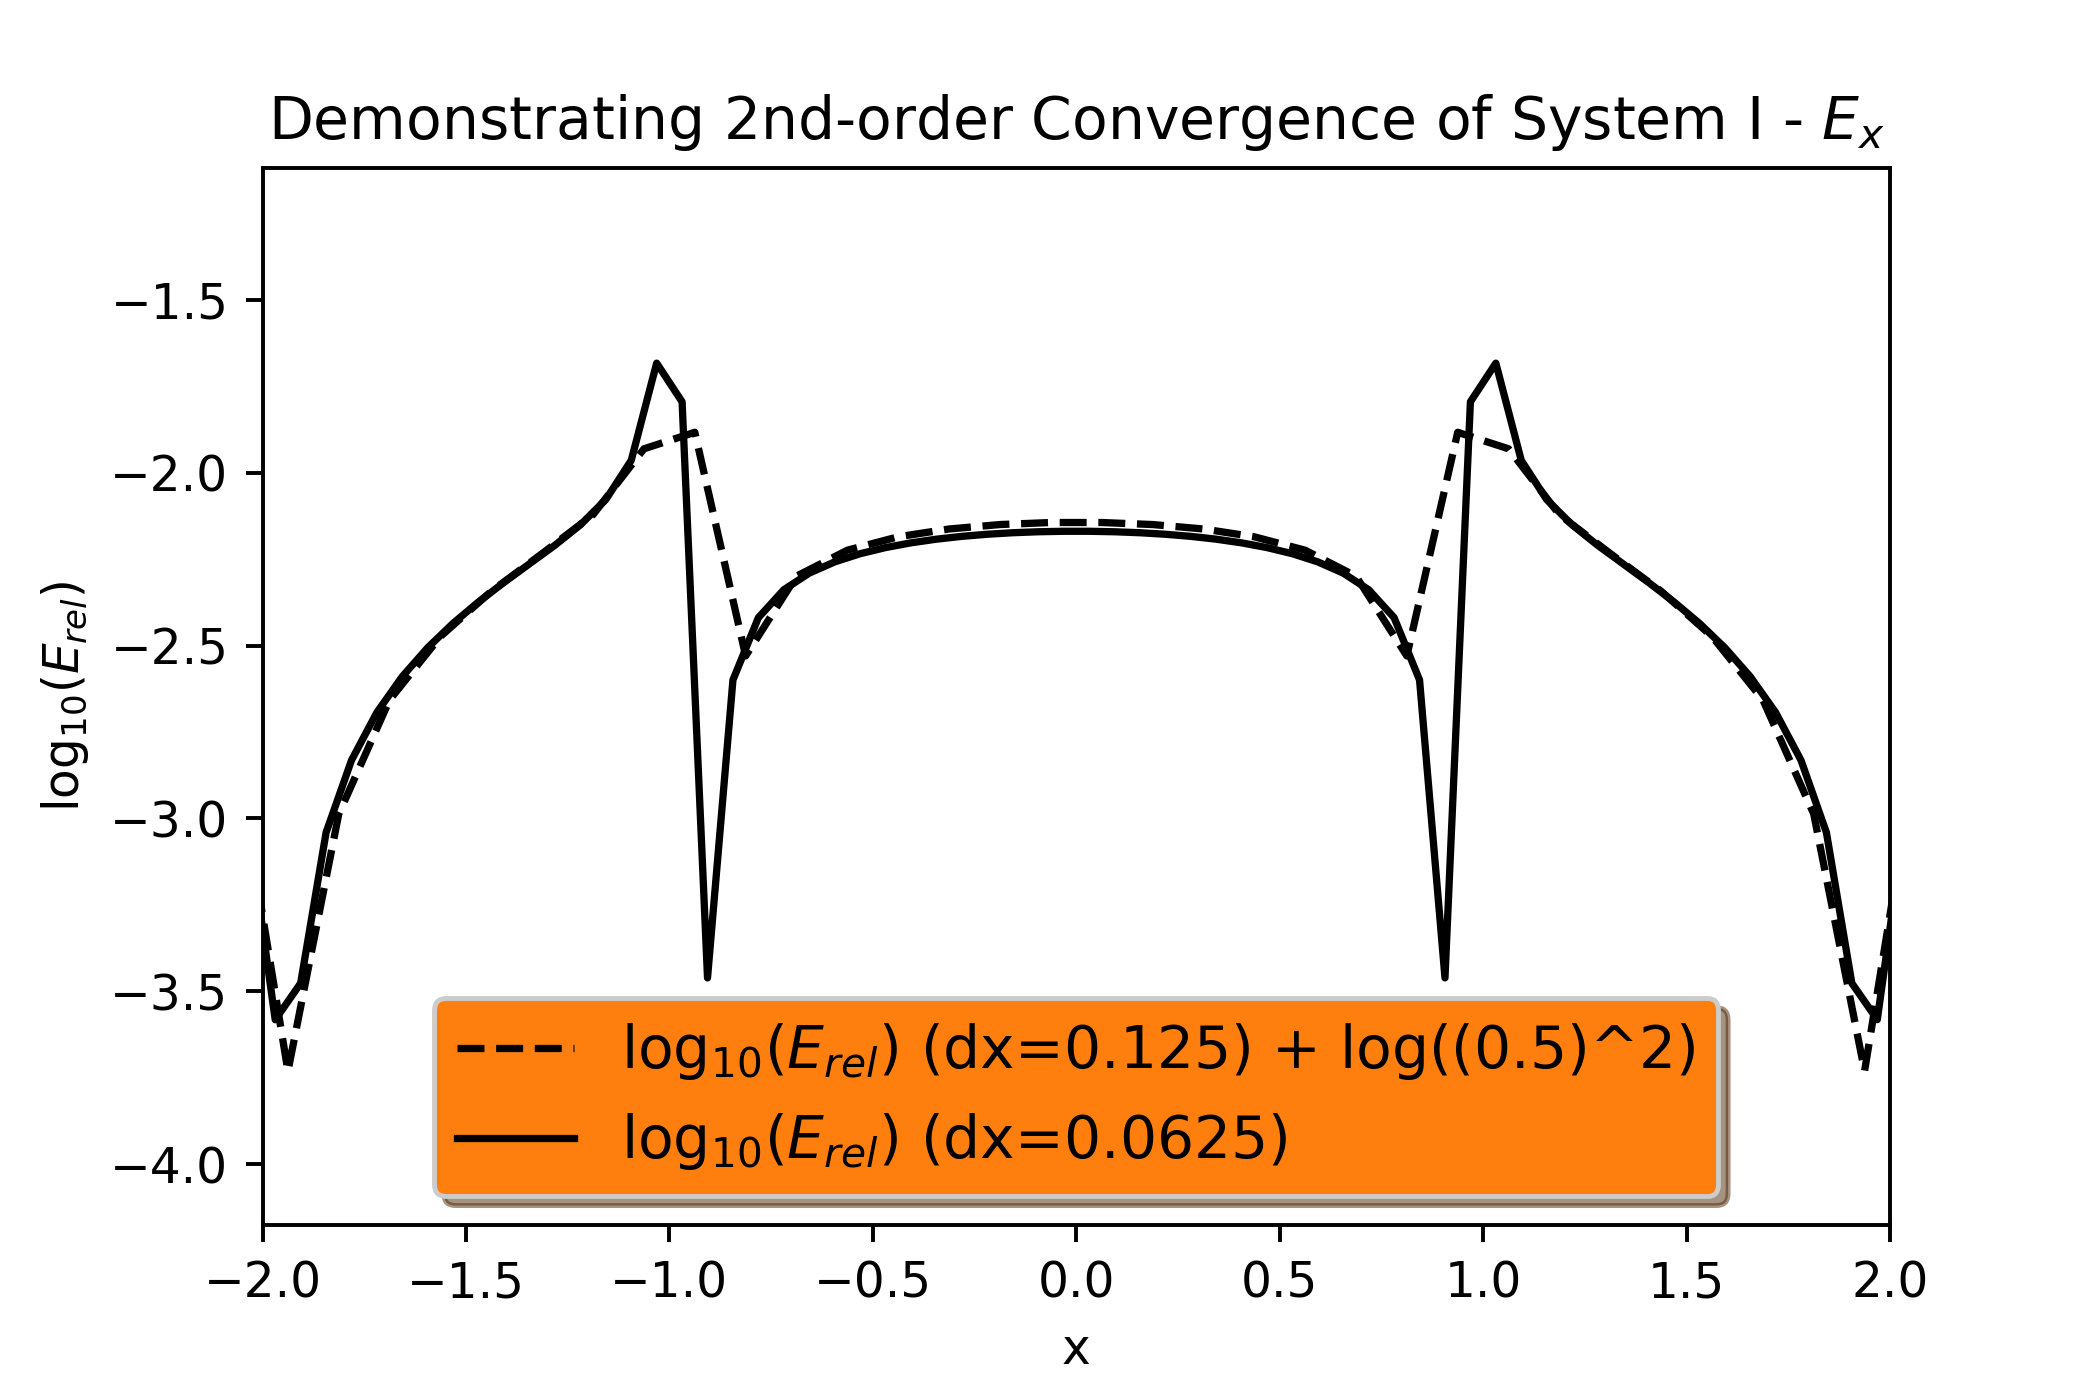

In [25]:
from IPython.display import Image
Image("MaxwellVacuum/example_parfiles/Ex-convergence.png", width=500, height=500)

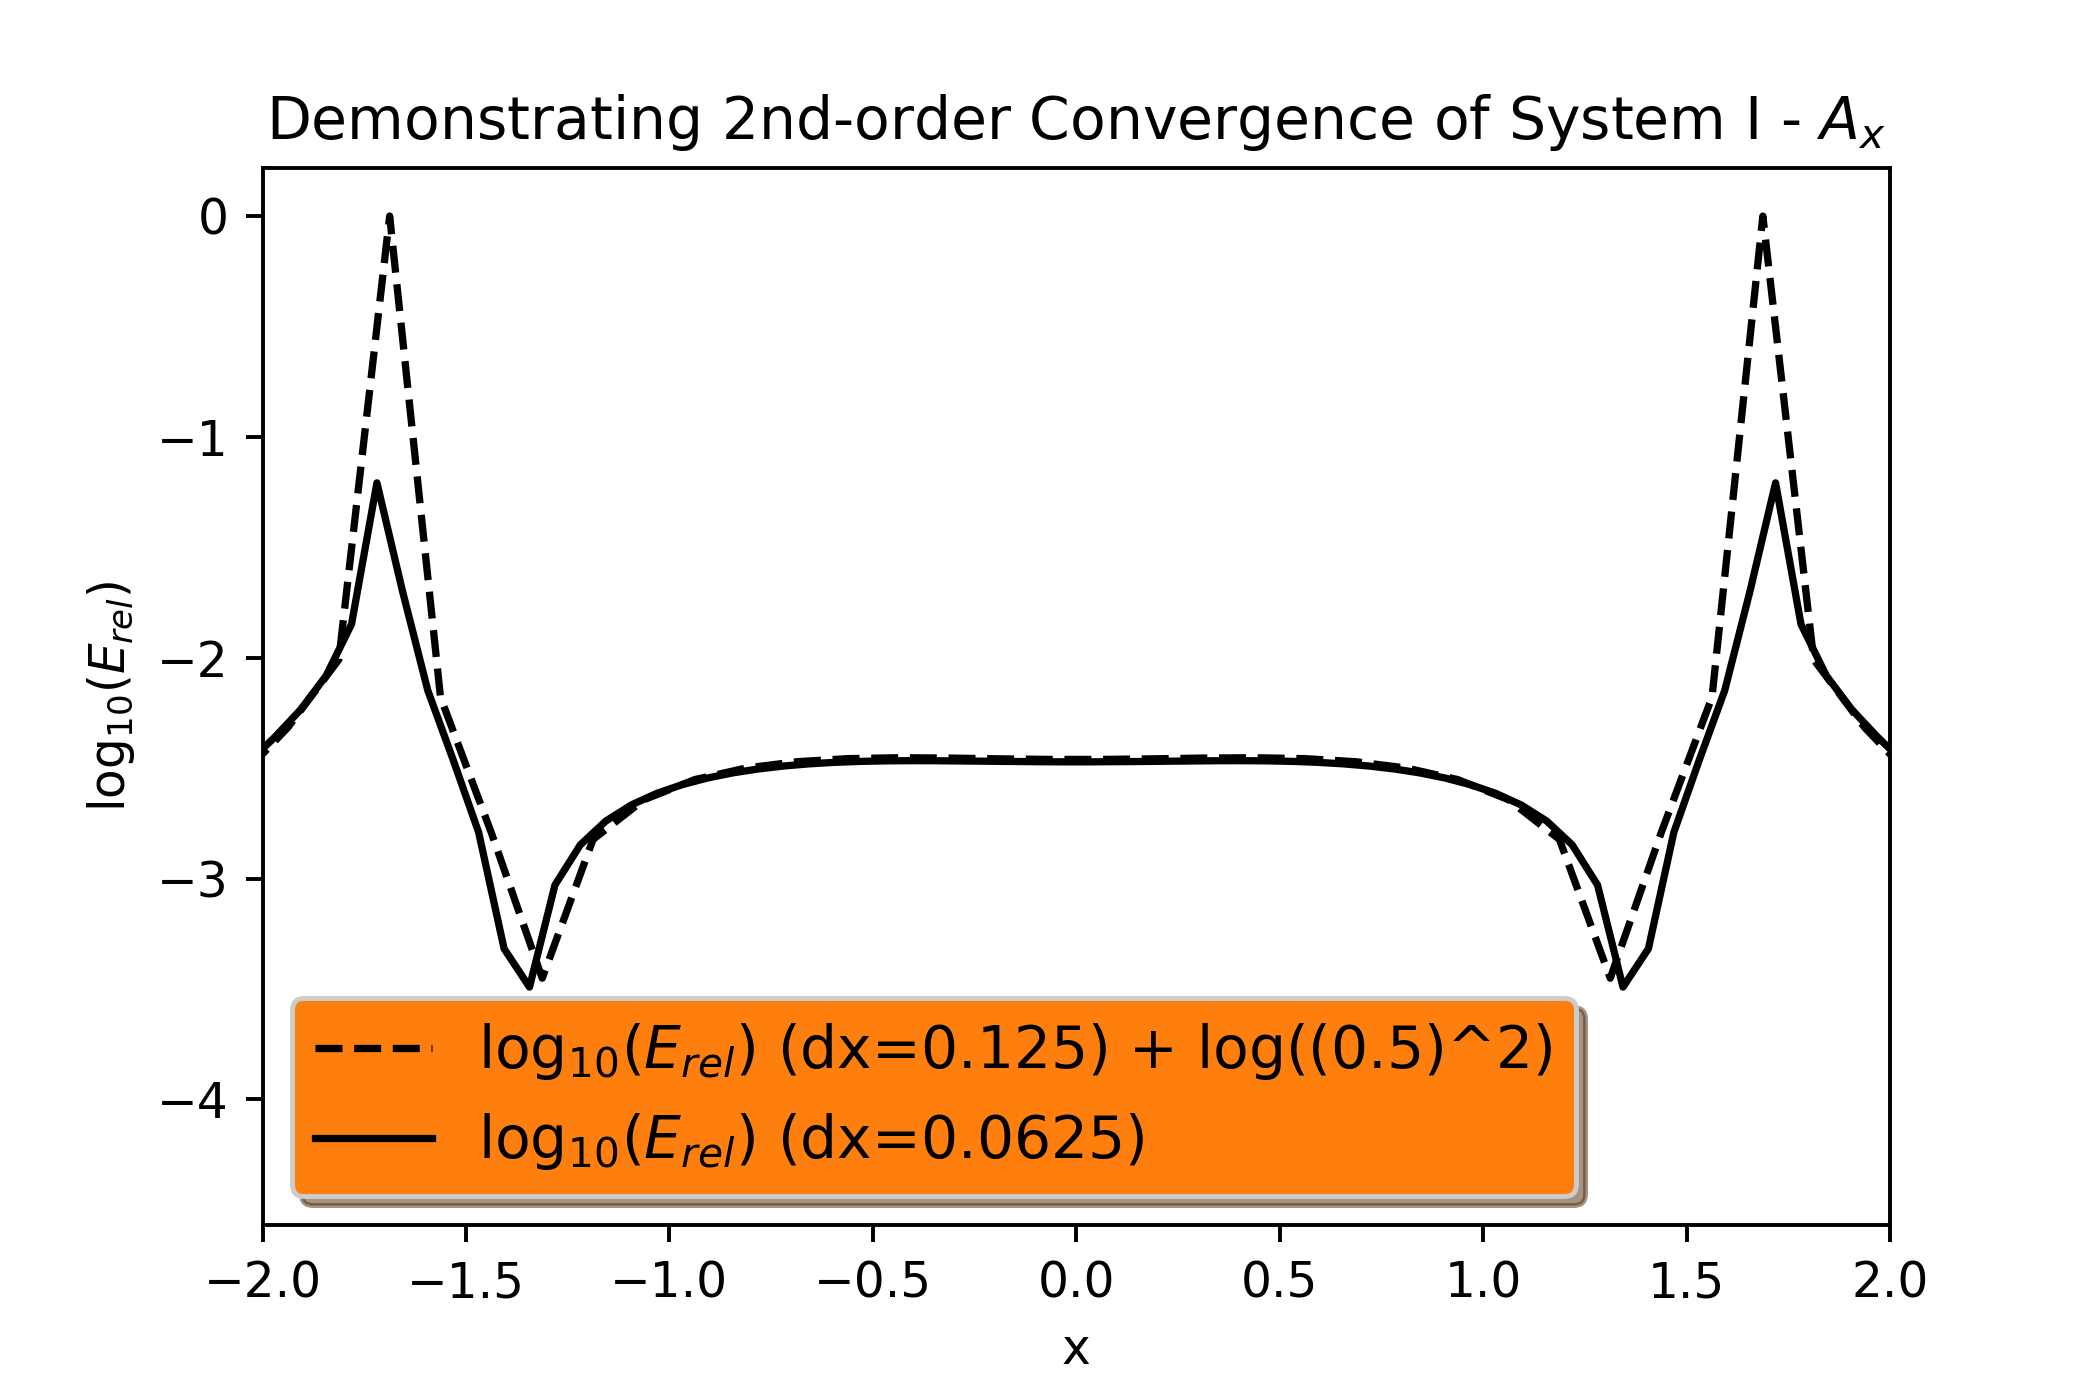

In [26]:
Image("MaxwellVacuum/example_parfiles/Ax-convergence.png", width=500, height=500)

<a id='errornodes'></a>

## Step 5.b: Behavior of Error Nodes \[Back to [top](#toc)\]
$$\label{errornodes}$$

Because System I is weakly hyperbolic (see [Tutorial-VacuumMaxwell_formulation_Cartesian](Tutorial-VacuumMaxwell_formulation_Cartesian.ipynb) for more discussion), zero speed error nodes of the constraint violation sit on our numerical grid, adding to the errors of our evolution variables. In contrast, System II is strongly hyperbolic, and the error nodes propagate away at the speed of light, leading to more stable evolution of the evolution variables. The plot below demostrates the qualitative behavior for both systems.

Contrast these plots to Figure 1 in [Knapp, Walker, & Baumgarte (2002)](https://arxiv.org/abs/gr-qc/0201051); we observe excellent qualitative agreement.

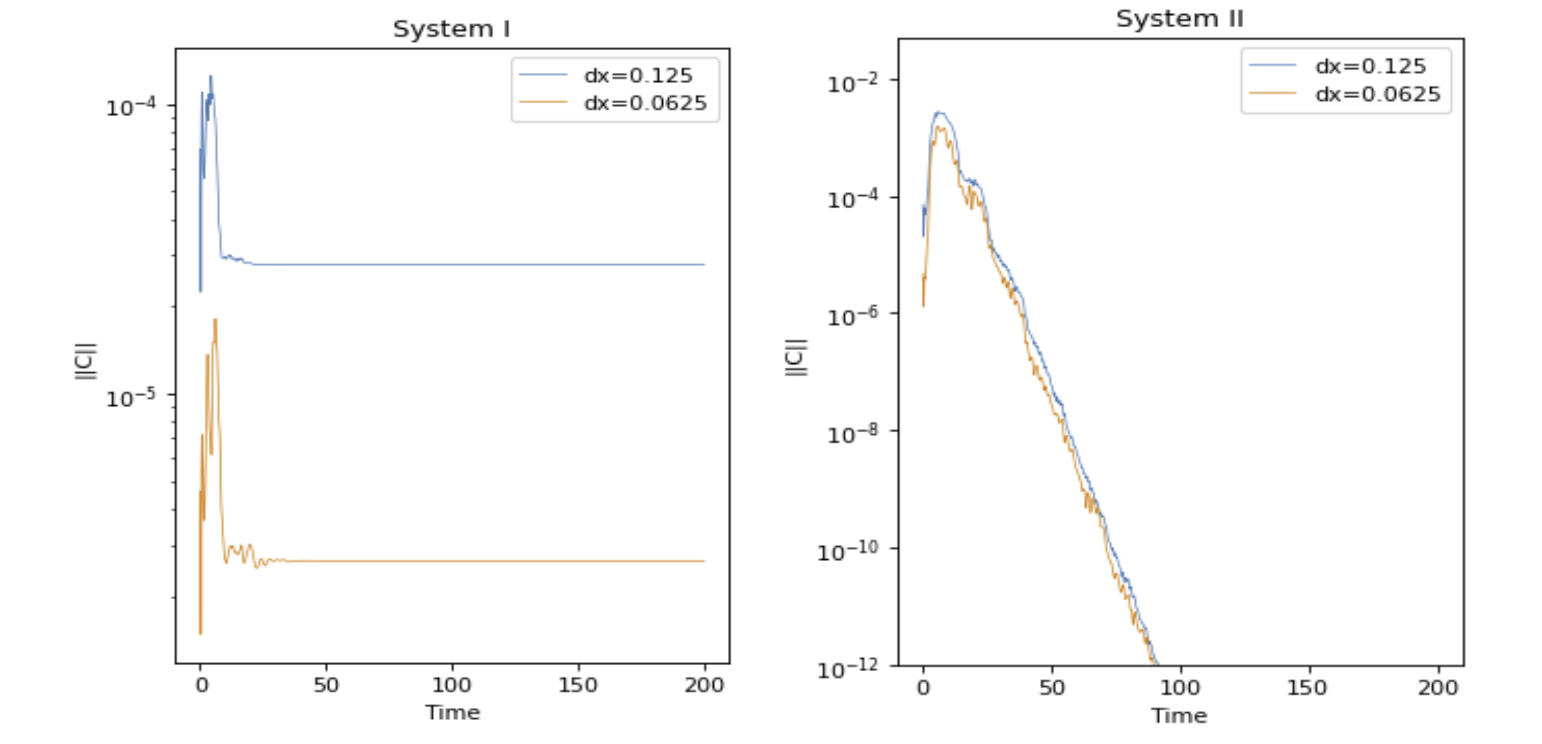

In [27]:
Image("MaxwellVacuum/example_parfiles/constraintviolation.png", width=500, height=500)

<a id='latex_pdf_output'></a>

# Step 6: Output this notebook to $\LaTeX$-formatted PDF file \[Back to [top](#toc)\]
$$\label{latex_pdf_output}$$

The following code cell converts this Jupyter notebook into a proper, clickable $\LaTeX$-formatted PDF file. After the cell is successfully run, the generated PDF may be found in the root NRPy+ tutorial directory, with filename
[Tutorial-ETK_thorn-MaxwellVacuum.pdf](Tutorial-ETK_thorn-MaxwellVacuum.pdf) (Note that clicking on this link may not work; you may need to open the PDF file through another means.)

In [28]:
import cmdline_helper as cmd    # NRPy+: Multi-platform Python command-line interface
cmd.output_Jupyter_notebook_to_LaTeXed_PDF("Tutorial-ETK_thorn-MaxwellVacuum")

Created Tutorial-ETK_thorn-MaxwellVacuum.tex, and compiled LaTeX file to
    PDF file Tutorial-ETK_thorn-MaxwellVacuum.pdf
